In [1]:
%who

Interactive namespace is empty.


In [2]:
! ls -l /g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005/

total 5982236
-rwxr-xr-x. 1 ad9701 w97 1499988336 Mar 23 17:56 SPEI3_awra_monthly_1981_2020_set1.nc
-rwxr-xr-x. 1 ad9701 w97 1503559704 Mar 23 19:02 SPEI3_awra_monthly_1981_2020_set2.nc
-rwxr-xr-x. 1 ad9701 w97 1504400024 Mar 23 20:05 SPEI3_awra_monthly_1981_2020_set3.nc
-rwxr-xr-x. 1 ad9701 w97 1507981896 Mar 23 20:33 SPEI3_awra_monthly_1981_2020_set4.nc
-rwxr-xr-x. 1 ad9701 w97   89936640 Mar 23 21:04 SPEI3_gleam_monthly_1981_2020.nc
-rw-r--r--. 1 ad9701 w97    5160083 Mar 31 17:32 spei_list_dry_byyear.pickle
-rw-r--r--. 1 ad9701 w97    5160257 Mar 31 17:32 spei_list_dry_JJAS_byyear.pickle
-rw-r--r--. 1 ad9701 w97    4789916 Mar 31 17:32 spei_list_dry_JJAS.pickle
-rw-r--r--. 1 ad9701 w97    4789547 Mar 31 17:32 spei_list_dry.pickle


In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
%run -i drought_2017to2019/dataInfo_and_functions.py

In [4]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005//'

fig_dir = 'figures/drought_2017to2020/PminusPET/baseline_198101_202005/'
figname_prefix = 'spei_3m'
fname_prefix = 'SPEI3'
vname = 'SPEI3'

time_slice = slice('2017-01-01', '2020-12-31')

filename = glob.glob(data_dir + vname + '_awra_monthly*.nc')
ds_awra = xr.open_mfdataset(filename)
ds_awra = ds_awra.sel(time = time_slice)

filename = glob.glob(data_dir + vname + '_gleam_monthly*.nc')[0]
ds_gleam = xr.open_dataset(filename)
ds_gleam = ds_gleam.sel(time = time_slice)

data_name = ['awra', 'gleam']
data_name_title = ['AWRA & AGCD', 'GLEAM & MSWEP']
dname_dict = dict(zip(data_name, data_name_title))
mask_file_dict = {data_name[0]: '/g/data/w97/ad9701/drought_2017to2020/precip_data/agcd_land_mask.nc',
                  data_name[1]: '/g/data/w97/ad9701/drought_2017to2020/PminusPET/gleam_land_mask.nc'}                
mask_list = []
for d in data_name:
    ds_mask = xr.open_dataset(mask_file_dict[d])
    mask_list.append(ds_mask)
mask_dict = dict(zip(data_name, mask_list))

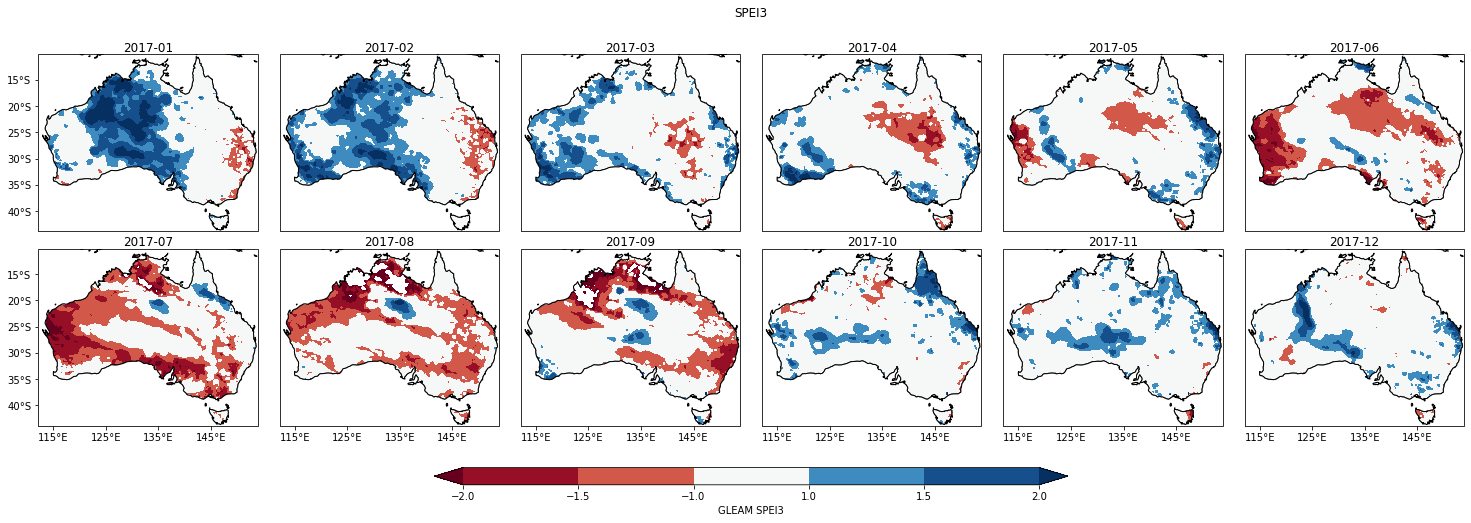

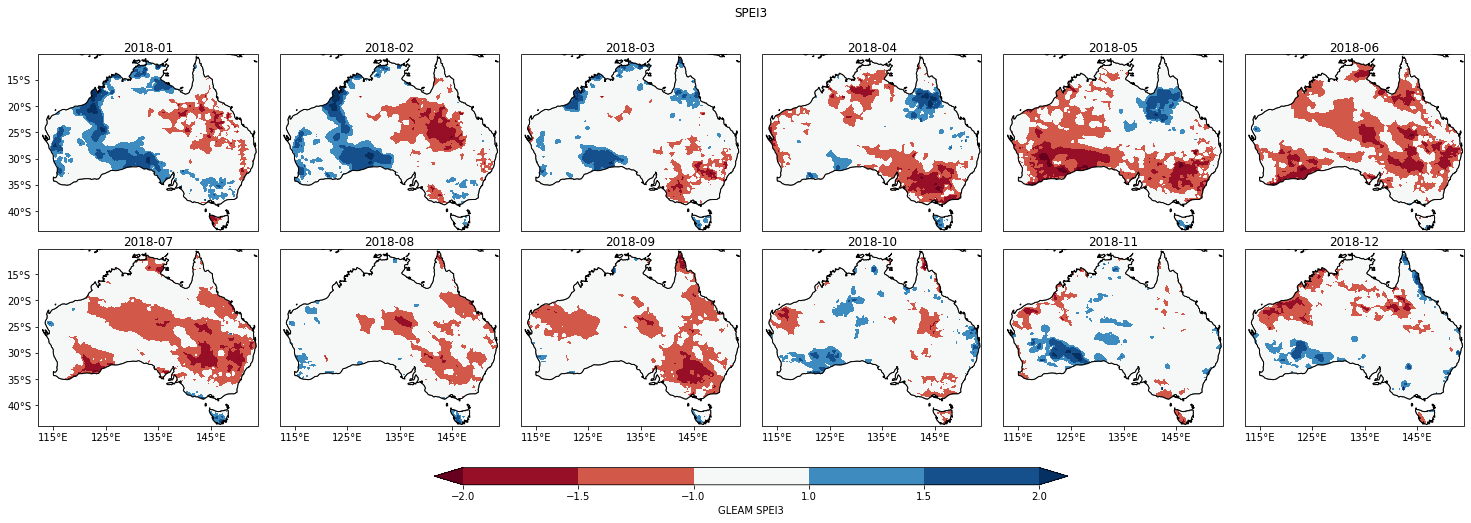

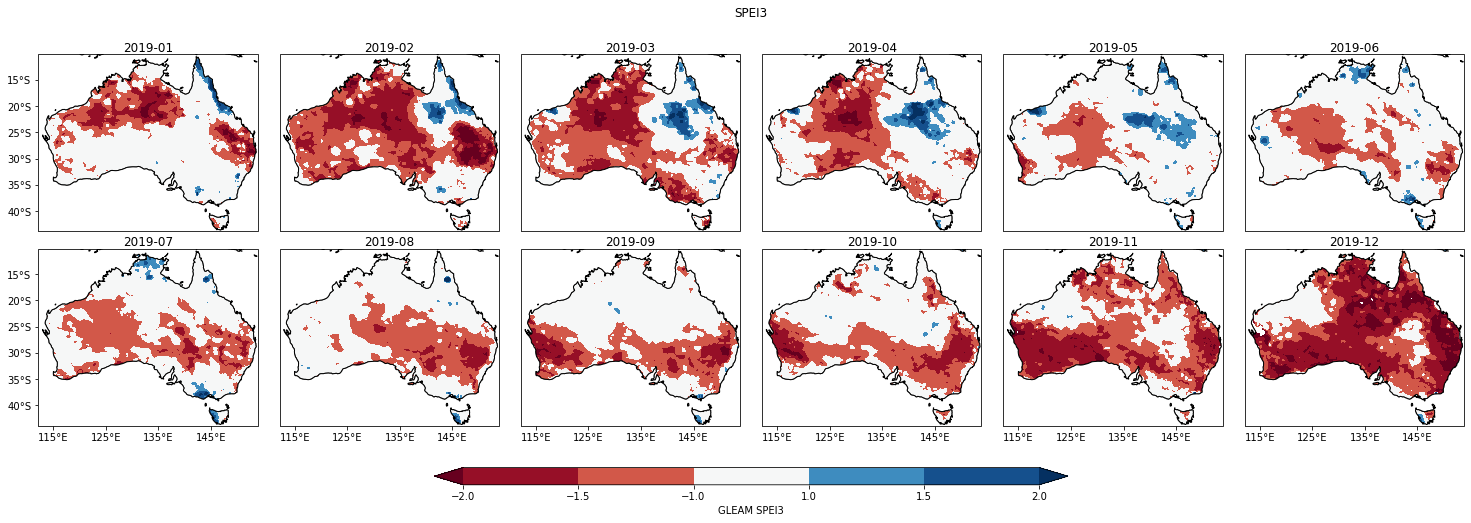

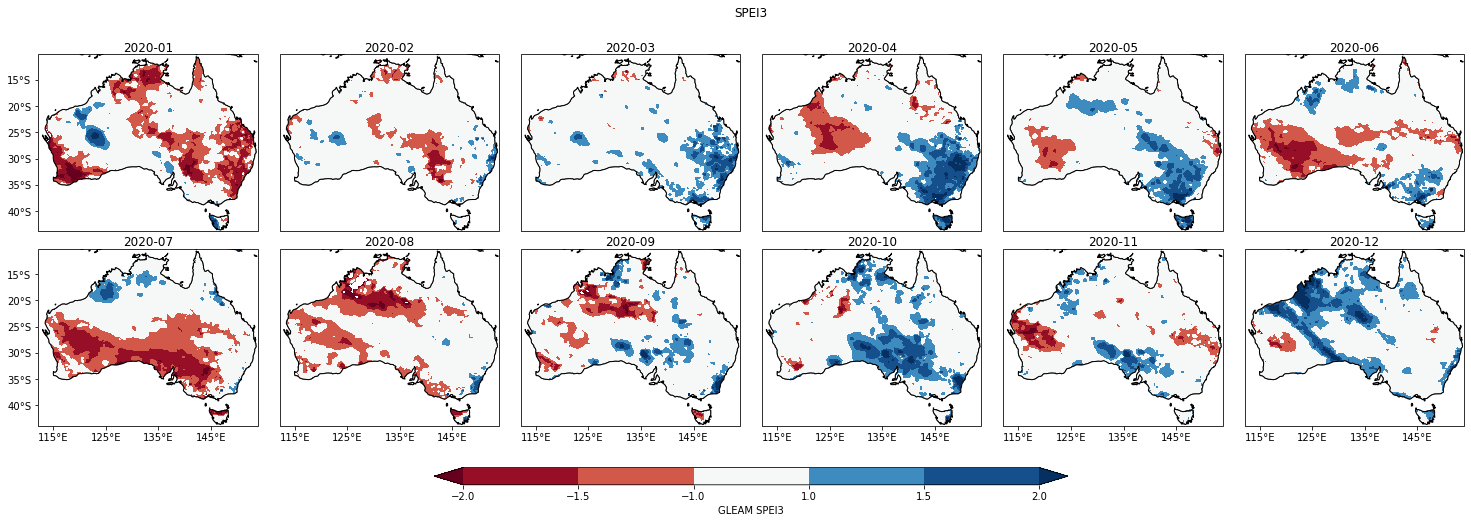

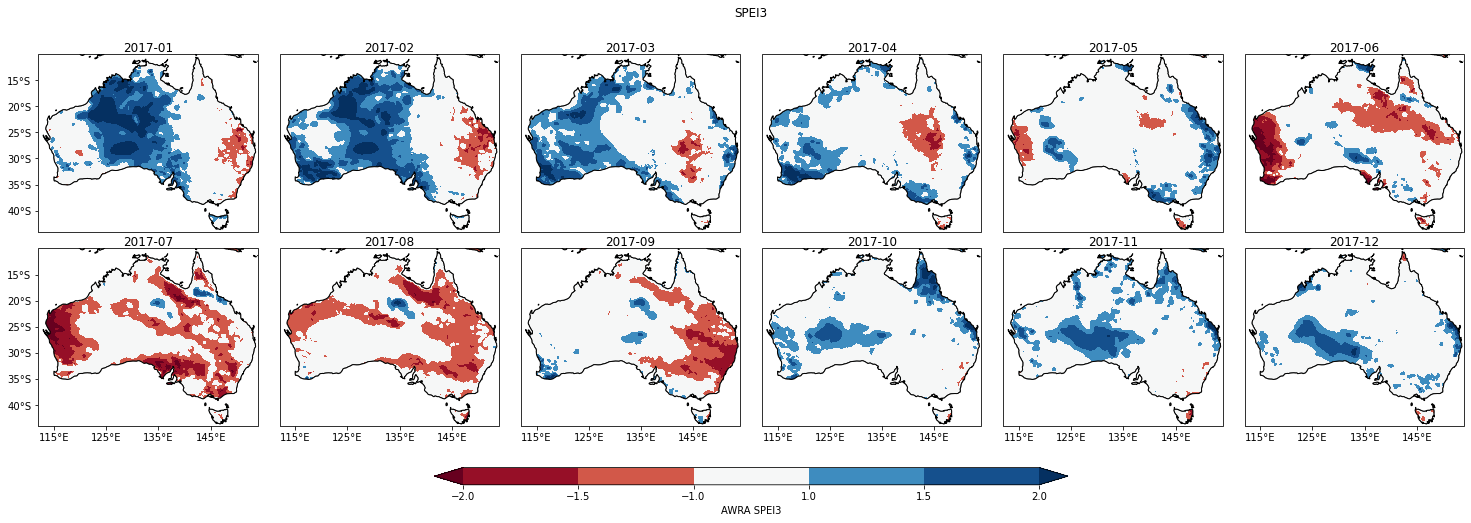

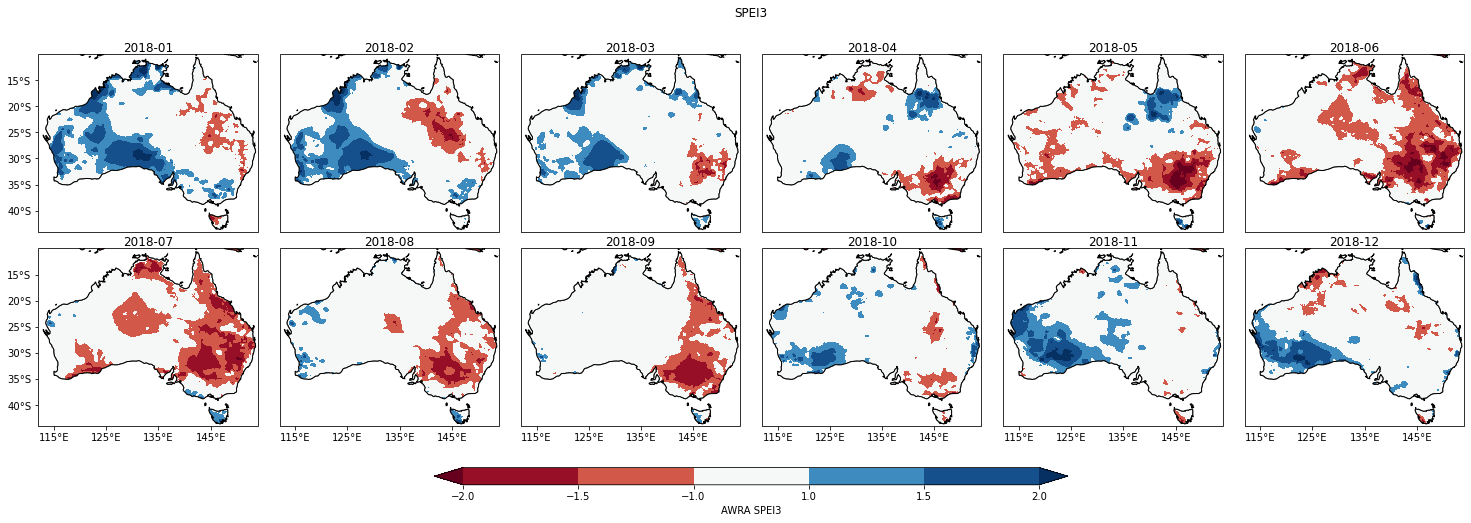

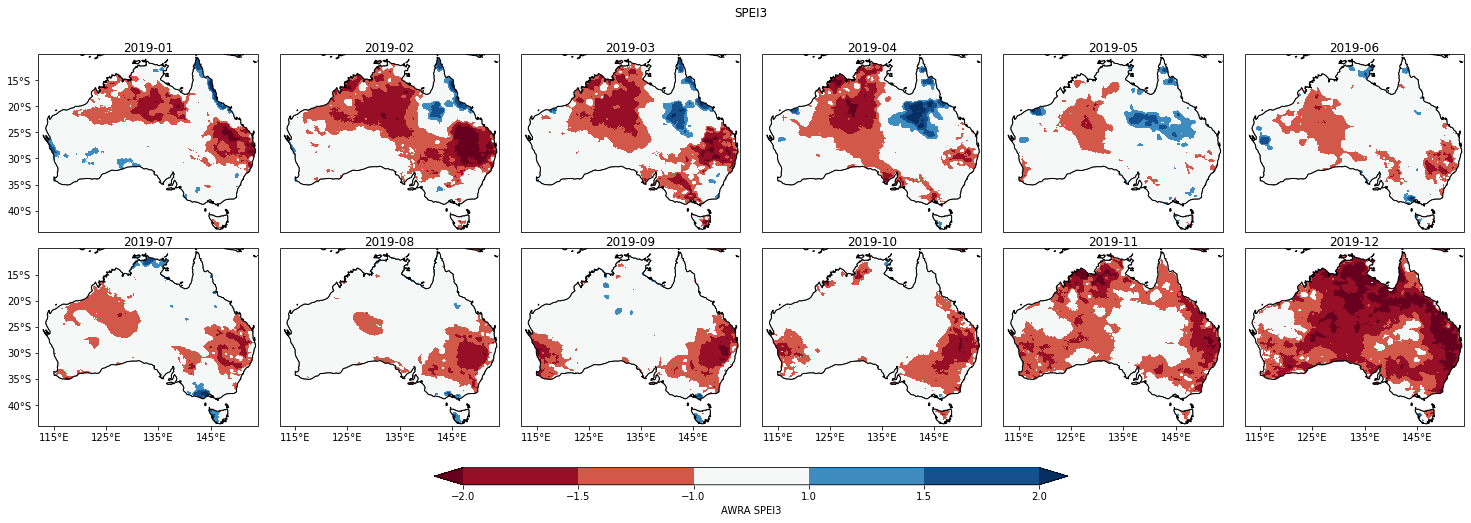

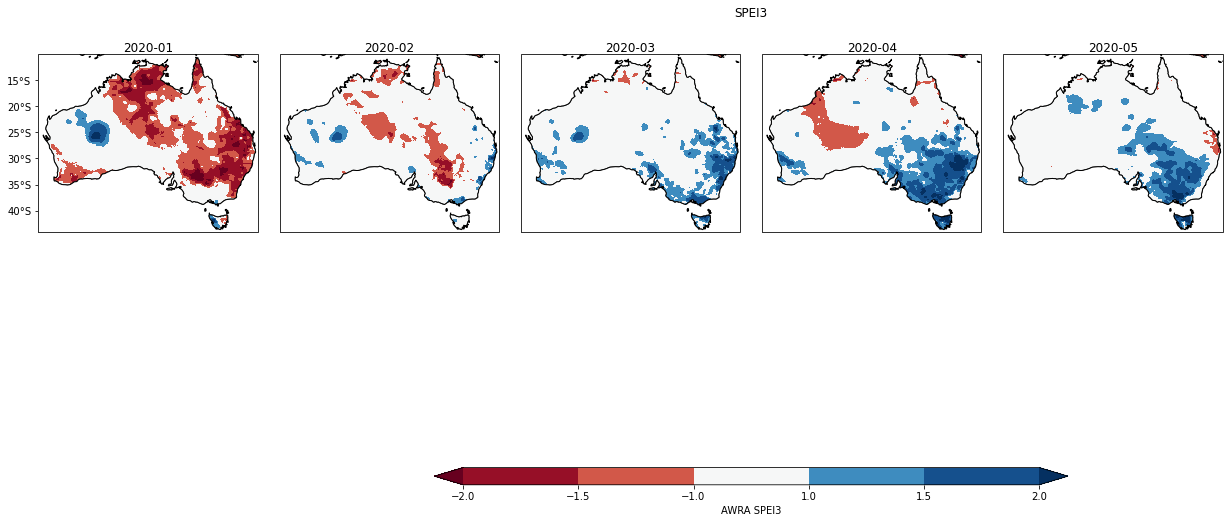

In [6]:
cmap = 'RdBu'
levels = [-2, -1.5, -1, 1, 1.5, 2]
main_title = vname

figname_prefix = 'v1_spei_3m'   # updating for figures with proper country borders

for d in ['gleam', 'awra']:
    for year in [2017, 2018, 2019, 2020]:
        if d =='awra':
            fname = glob.glob(data_dir + fname_prefix + '*' + d  + '*.nc')
            ds = xr.open_mfdataset(fname)
        else:
            fname = glob.glob(data_dir + fname_prefix + '*' + d  + '*.nc')[0]
            ds = xr.open_dataset(fname)
        da = ds[vname].sel(time = slice(str(year), str(year))).load()
        ds_mask = mask_dict[d]
        da = da*ds_mask['land_mask']

        lat_size = abs((ds.lat[0]-ds.lat[-1]).values)
        lon_size = abs((ds.lon[0]-ds.lon[-1]).values)
        aspect = lon_size/lat_size

        da_plot = da.groupby('time.month').mean().rename(d + ' ' + vname + ' ' + str(year))
        plot_list = [da_plot.sel(month=i) for i in da_plot.month.values]
        subplot_title = np.datetime_as_string(da.time.values, unit='M')

        out_figname = figname_prefix + '_' + str(year) + '_bymon' + '_' + d + '.png'
        draw_spatial_plot_12panels(ds_list = plot_list, cmap = cmap, levels = levels, subplot_title = subplot_title, main_title = main_title, out_dir = fig_dir, out_figname = out_figname, add_cbar = True, cbar_label = d.upper() + ' ' + vname)

        # da.groupby('time.month').mean().rename(dname_dict[d] + ' ' + vname + ' ' + str(year)).plot(x = "lon", y = "lat", col = "month", col_wrap = 6, aspect = aspect, size = 3, cmap = "RdBu", levels = levels) #"RdBu_r") "YlGnBu"
        # plt.savefig(out_dir + figname_prefix + '_' + str(year) + '_bymon' + '_' + d + '.png')
        # del ds, fname

In [46]:
spei_list_dry = []
spei_list_dry_byyear = []
spei_list_dry_JJAS = []
spei_list_dry_JJAS_byyear = []
mon_sel = [6, 7, 8, 9]

dry_thresh = -1  # values below this threshold are atleast moderately dry (WMO document)
time_slice = slice('2017-01-01', '2019-12-31')
vname = 'SPEI3'

data_list = [ds_awra, ds_gleam]
for i_ds in range(len(data_list)):
    ds = data_list[i_ds]
    da1 = ds[vname].where(ds[vname]<= dry_thresh).sel(time = time_slice).count('time').rename('count months')
    da1_year = ds[vname].where(ds[vname]<= dry_thresh).sel(time = time_slice).groupby('time.year').count('time').rename('count months')
    da1 = da1*mask_list[i_ds]['land_mask']
    da1_year = da1_year*mask_list[i_ds]['land_mask']
    spei_list_dry.append(da1)
    spei_list_dry_byyear.append(da1_year)
    del da1, da1_year
    
    da1_temp = ds[vname].where(ds[vname]<= dry_thresh).sel(time = time_slice)
    da1 = da1_temp.sel(time=da1_temp.time.dt.month.isin(mon_sel)).count('time').rename('count months')
    da1_year = da1_temp.sel(time=da1_temp.time.dt.month.isin(mon_sel)).groupby('time.year').count('time').rename('count months')
    da1 = da1*mask_list[i_ds]['land_mask']
    da1_year = da1_year*mask_list[i_ds]['land_mask']
    spei_list_dry_JJAS.append(da1)
    spei_list_dry_JJAS_byyear.append(da1_year)
    del da1, da1_year

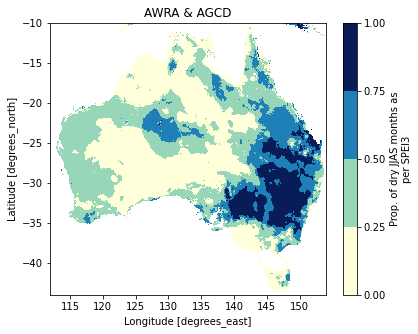

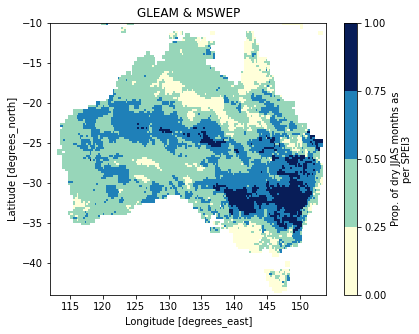

In [47]:
plot_list = spei_list_dry_JJAS
total_months = 4*3
new_varname = 'Prop. of dry JJAS months as per SPEI3'
fig_prefix = 'Prop_dry_JJAS_months_asper_spei3'

levels = [0, 0.25, 0.5, 0.75, 1.0001]

for idata in range(len(data_name)):
    lat_size = abs((plot_list[idata].lat[0]-plot_list[idata].lat[-1]).values)
    lon_size = abs((plot_list[idata].lon[0]-plot_list[idata].lon[-1]).values)
    aspect = lon_size/lat_size

    (plot_list[idata]/total_months).rename(new_varname).plot(x = "lon", y = "lat", aspect = aspect, size = 5, levels = levels, cmap = "YlGnBu") #, cmap = "RdBu", levels = levels
    plt.title(dname_dict[data_name[idata]])
    plt.savefig(fig_dir + fig_prefix + '_' + data_name[idata] + '.png')

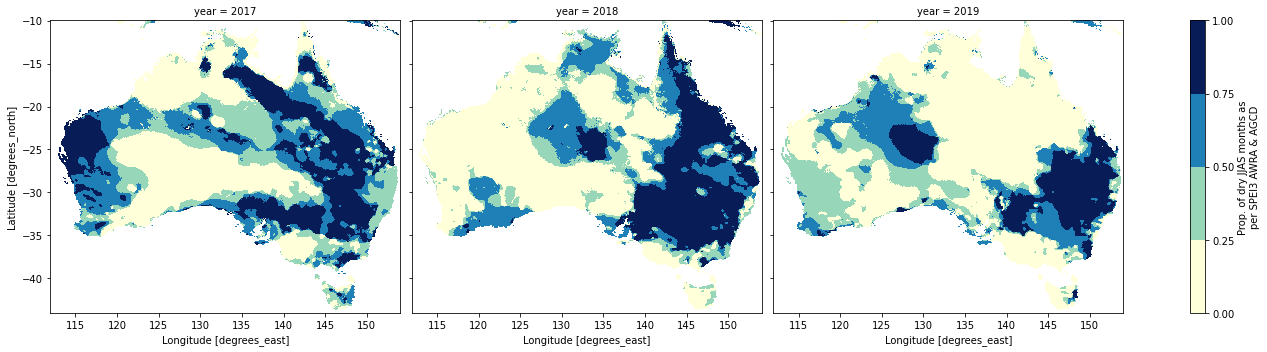

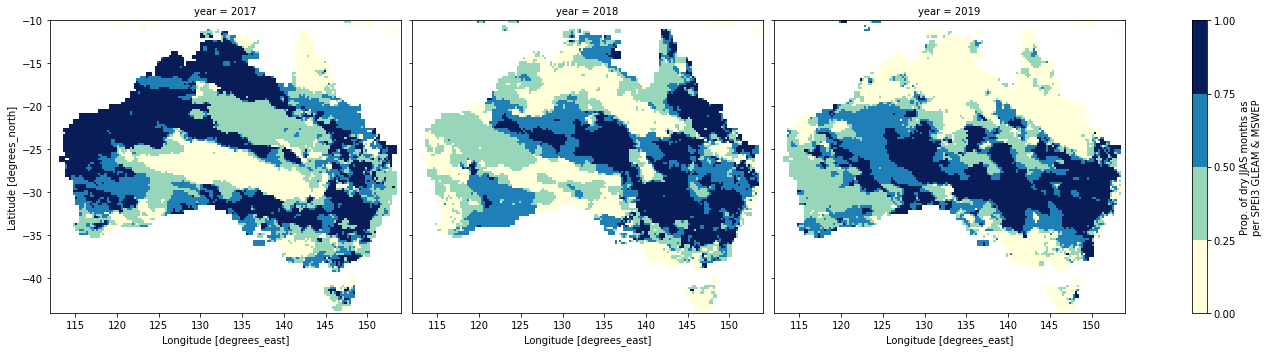

In [48]:
plot_list = spei_list_dry_JJAS_byyear
total_months = 4
new_varname = 'Prop. of dry JJAS months as per SPEI3'
fig_prefix = 'Prop_dry_JJAS_months_asper_spei3_byyear'

levels = [0, 0.25, 0.5, 0.75, 1.0001]

for idata in range(len(data_name)):
    lat_size = abs((plot_list[idata].lat[0]-plot_list[idata].lat[-1]).values)
    lon_size = abs((plot_list[idata].lon[0]-plot_list[idata].lon[-1]).values)
    aspect = lon_size/lat_size

    (plot_list[idata]/total_months).rename(new_varname + ' ' + dname_dict[data_name[idata]]).plot(x = "lon", y = "lat", aspect = aspect, size = 5, levels = levels, cmap = "YlGnBu", col="year") #, cmap = "RdBu", levels = levels
    # plt.title(data_name[idata])
    plt.savefig(fig_dir + fig_prefix + '_' + data_name[idata] + '.png')

In [ ]:
sp

In [50]:
# save the proportion of dry months into a pickle object; to be used for analysis to determine the focus region

# list objects to be saved
# spei_list_dry
# spei_list_dry_byyear
# spei_list_dry_JJAS
# spei_list_dry_JJAS_byyear

import pickle

out_file1 = data_dir + 'spei_list_dry.pickle'
with open(out_file1, 'wb') as handle:
    pickle.dump(spei_list_dry, handle)
    
out_file1 = data_dir + 'spei_list_dry_byyear.pickle'
with open(out_file1, 'wb') as handle:
    pickle.dump(spei_list_dry_byyear, handle)
    
out_file1 = data_dir + 'spei_list_dry_JJAS.pickle'
with open(out_file1, 'wb') as handle:
    pickle.dump(spei_list_dry_JJAS, handle)
    
out_file1 = data_dir + 'spei_list_dry_JJAS_byyear.pickle'
with open(out_file1, 'wb') as handle:
    pickle.dump(spei_list_dry_JJAS_byyear, handle)

In [51]:
data_dir

'/g/data/w97/ad9701/drought_2017to2020/PminusPET/SPEI3_baseline_198101_202005//'

### Scratch Space

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


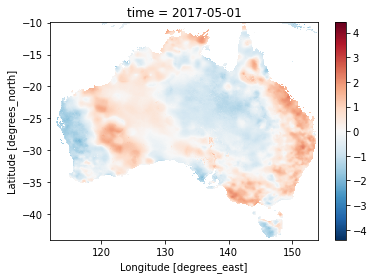

In [16]:
(ds_awra['SPEI3'][4,:,:]*ds_mask['land_mask']).plot()

In [6]:
ds_mask = xr.open_dataset('/g/data/w97/ad9701/drought_2017to2020/precip_data/agcd_land_mask.nc')
ds_mask

<xarray.Dataset>
Dimensions:    (lon: 841, lat: 681)
Coordinates:
  * lon        (lon) float32 112.0 112.1 112.1 112.2 ... 153.9 153.9 153.9 154.0
  * lat        (lat) float32 -44.0 -43.95 -43.9 -43.85 ... -10.1 -10.05 -10.0
Data variables:
    land_mask  (lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Fri Mar 11 14:51:44 2022: cdo remapnn,spi_3m_agcd_monthly_1...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [25]:
ds_gleam = xr.open_dataset('/g/data/w97/ad9701/drought_2017to2020/PminusPET/Ep_gleam_monthly_1980_2020.nc')
land_mask = xr.where(~np.isnan(ds_gleam['Ep'][200,:,:]), 1, np.nan).drop('time').rename('land_mask')
land_mask.to_netcdf('/g/data/w97/ad9701/drought_2017to2020/PminusPET/gleam_land_mask.nc')

In [4]:
alldata_dict

{'mswep': {'full_path': ['/g/data/fj4/SatellitePrecip/MSWEP_V280/Past/Monthly/',
   '/g/data/fj4/SatellitePrecip/MSWEP_V280/NRT/Monthly/'],
  'file_name': '*.nc',
  'varname': 'precipitation',
  'lat_slice': slice(-10, -44, None),
  'lon_slice': slice(112, 154, None),
  'units': 'mm month-1',
  'rename_latlon': False,
  'land_mask': False},
 'chirps': {'full_path': '/g/data/w97/ad9701/CHIRPS-2.0/global_monthly/netcdf/',
  'file_name': 'chirps-v2.0.monthly.nc',
  'varname': 'precip',
  'lat_slice': slice(-44, -10, None),
  'lon_slice': slice(112, 154, None),
  'units': 'mm month-1',
  'rename_latlon': True,
  'land_mask': True},
 'agcd': {'full_path': '/g/data/zv2/agcd/v1/precip/total/r005/01month/',
  'file_name': 'agcd_v1_precip_total_r005_monthly_*.nc',
  'varname': 'precip',
  'lat_slice': slice(-44, -10, None),
  'lon_slice': slice(112, 154, None),
  'units': 'mm month-1',
  'rename_latlon': False,
  'land_mask': False},
 'gleam': {'full_path': '/g/data/ua8/GLEAM_v3-5/v3-5a/monthly